In [23]:
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
from dnn_utils import sigmoid, sigmoid_backward, relu, relu_backward

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

**Transforming dependant variable from 0/1 to -1/1**

In [24]:
def transformTarVar(data, dependantVarColumn):
  unique, counts = np.unique(data[:,dependantVarColumn], return_counts=True)
  print(np.asarray((unique, counts)).T)
  data[:,dependantVarColumn][data[:,dependantVarColumn]==0] = -1
  return data

**Segregating data into train and dev set**

In [25]:
def trainTestTransform(data, sizeTrainingData):
  train_size = int(data.shape[0] * sizeTrainingData)
  train_data, test_data = data[:train_size,:], data[train_size:,:]
  Y_train, X_train = train_data[:, -1], train_data[:, :-1]
  Y_test, X_test = test_data[:, -1], test_data[:, :-1]

  Y_train, Y_test = Y_train.reshape((1,Y_train.shape[0])), Y_test.reshape((1,Y_test.shape[0]))
  X_train = X_train.T

  return X_train, X_test, Y_train, Y_test

#**Initializing Parameters for the Neural Network**

**Random Parameter Initialization**

In [26]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
     
    return parameters

**He Parameter Initialization**

In [27]:
def initialize_parameters_deep_He(layer_dims):
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2/layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
     
    return parameters

**Xavier Parameter Initialization**

In [28]:
def initialize_parameters_deep_Xavier(layer_dims):
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1/layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l - 1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
     
    return parameters

#**Neural Network architecture**

**Linear Feed Forward Network**

In [29]:
def linear_forward(A, W, b):

    Z = np.dot(W,A) + b  
    
    cache = (A, W, b)
    
    return Z, cache

**Activating Linear Feed Forward Network**

In [30]:
def linear_activation_forward(A_prev, W, b, activation):
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

**Feed Forward for all the layers**

In [31]:
def L_model_forward(X, parameters):

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network

    for l in range(1, L):
        A_prev = A 

        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], "relu")
        caches.append(cache)

    AL, cache = linear_activation_forward(A, parameters["W"+str(l+1)], parameters["b"+str(l+1)], "sigmoid")
    caches.append(cache)
          
    return AL, caches

**Cost Function Calculation**

In [32]:
def compute_cost(AL, Y):
    
    m = Y.shape[1]

    cost = np.sum(np.dot(np.log(AL + 10**-6),Y.T)+np.dot(np.log(1-AL + 10**-6),(1-Y).T))/-m
    
    cost = np.squeeze(cost)

    
    return cost

**Linear Feed Backward**

In [33]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = np.dot(dZ, A_prev.T)/m
    db = np.sum(dZ,axis=1, keepdims=True)/m
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

**Gradient Calculation**

In [34]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)        
    
    return dA_prev, dW, db

**Gradient calculation for the entire network**

In [35]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, "sigmoid")
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp 
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dA_prev_temp, current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp      

    return grads

In [36]:
import pdb

In [37]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient. Initialized with zeros.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient. Initialized with zeros.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
    # (approx. 4 lines)
        # v["dW" + str(l)] = ...
        # v["db" + str(l)] = ...
        # s["dW" + str(l)] = ...
        # s["db" + str(l)] = ...
    # YOUR CODE STARTS HERE
        v["dW" + str(l)] = np.zeros(parameters["W"+str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters["b"+str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters["W"+str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters["b"+str(l)].shape)   
    
    # YOUR CODE ENDS HERE
    
    return v, s

In [38]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    t -- Adam variable, counts the number of taken steps
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(1, L + 1):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        # (approx. 2 lines)
        # v["dW" + str(l)] = ...
        # v["db" + str(l)] = ...
        # YOUR CODE STARTS HERE
        v["dW" + str(l)] = beta1 * v["dW"+str(l)] + (1-beta1) * grads["dW"+str(l)]
        v["db" + str(l)] = beta1 * v["db"+str(l)] + (1-beta1) * grads["db"+str(l)]      
        
        # YOUR CODE ENDS HERE

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        # (approx. 2 lines)
        # v_corrected["dW" + str(l)] = ...
        # v_corrected["db" + str(l)] = ...
        # YOUR CODE STARTS HERE
        v_corrected["dW" + str(l)] = v["dW"+str(l)] / (1 - (beta1)**t)
        v_corrected["db" + str(l)] = v["db"+str(l)] / (1 - (beta1)**t)     
        
        # YOUR CODE ENDS HERE

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        #(approx. 2 lines)
        # s["dW" + str(l)] = ...
        # s["db" + str(l)] = ...
        # YOUR CODE STARTS HERE
        s["dW" + str(l)] = beta2*s["dW" + str(l)] + (1-beta2) * grads["dW"+str(l)] ** 2
        s["db" + str(l)] = beta2*s["db" + str(l)] + (1-beta2) * grads["db"+str(l)] ** 2        
        
        # YOUR CODE ENDS HERE

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        # (approx. 2 lines)
        # s_corrected["dW" + str(l)] = ...
        # s_corrected["db" + str(l)] = ...
        # YOUR CODE STARTS HERE
        s_corrected["dW" + str(l)] = s["dW"+str(l)] / (1 - (beta2)**t)
        s_corrected["db" + str(l)] = s["db"+str(l)] / (1 - (beta2)**t)       
        
        # YOUR CODE ENDS HERE

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        # (approx. 2 lines)
        # parameters["W" + str(l)] = ...
        # parameters["b" + str(l)] = ...
        # YOUR CODE STARTS HERE
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * v_corrected["dW" + str(l)] / \
                                                                (np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * v_corrected["db" + str(l)] / \
                                                                (np.sqrt(s_corrected["db" + str(l)]) + epsilon)        
        
        # YOUR CODE ENDS HERE

    return parameters, v, s, v_corrected, s_corrected

**Updating Parameters**

In [39]:
def update_parameters(params, grads, learning_rate):
    parameters = params.copy()
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(L):
        parameters["W" + str(l+1)] = params["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = params["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]     
        
    return parameters

**Defining the model**

In [40]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.000004, num_iterations = 200, optimizer = None, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, print_cost=False):
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep_He(layers_dims)

    # Initialize the optimizer
    if optimizer == None:
        update_function = update_parameters
    # elif optimizer == "momentum":
    #     v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
        update_function = update_parameters_with_adam
        
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.

        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        if optimizer == None:
                parameters = update_parameters(parameters, grads, learning_rate)

        elif optimizer == "adam":
                t = i + 1 # Adam counter
                parameters, v, s, _, _ = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)

                
        # Print the cost every 1/10th of iterations
        disp_cost = num_iterations/10
        if print_cost and i % disp_cost == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % disp_cost == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs, caches

**Model Evaluation**

In [41]:
def predict(X, y, parameters):
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # convert probas to -1/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = -1
    
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p


In [42]:
def plot_costs(costs, learning_rate=0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [43]:
data = np.loadtxt("data_banknote_authentication.csv", delimiter=',')
# data = np.loadtxt("adult.data", unpack=True)
dependantVarColumn = 4 # 0 indexed column number of the dependant variable
sizeTrainingData = 0.8 # range 0 to 1 as it is in percentage

**Defining Hyperparameters**

In [44]:
learning_rate = 0.0004

layers_dims_optimal = [4, 4, 1] #  3-layer model
layers_dims = [100]*8
layers_dims.insert(0,4)
layers_dims.append(1)

num_iterations = 200

[[ -1. 762.]
 [  1. 610.]]
Cost after iteration 0: 3.8674405165504053
Cost after iteration 20: -5.768905736970275


/content/dnn_utils.py:15: RuntimeWarning: overflow encountered in exp
  A = 1/(1+np.exp(-Z))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/content/dnn_utils.py:76: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-Z))
/content/dnn_utils.py:77: RuntimeWarning: invalid value encountered in multiply
  dZ = dA * s * (1-s)


Cost after iteration 40: nan
Cost after iteration 60: nan
Cost after iteration 80: nan
Cost after iteration 100: nan
Cost after iteration 120: nan
Cost after iteration 140: nan
Cost after iteration 160: nan
Cost after iteration 180: nan
Cost after iteration 199: nan


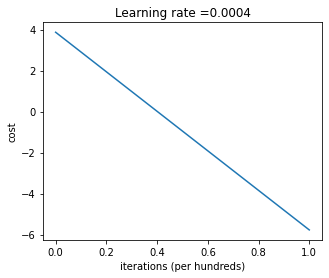

Cost after iteration 0: 0.310797931873401
Cost after iteration 20: -0.29739495904480634
Cost after iteration 40: -0.9755524919901398
Cost after iteration 60: -1.9302033163584924
Cost after iteration 80: -3.514662484634963
Cost after iteration 100: -5.831062194446321
Cost after iteration 120: -7.077624173057196
Cost after iteration 140: -7.068721797732049
Cost after iteration 160: -7.036632323457947
Cost after iteration 180: -6.9784885612050775
Cost after iteration 199: -6.868080348683816


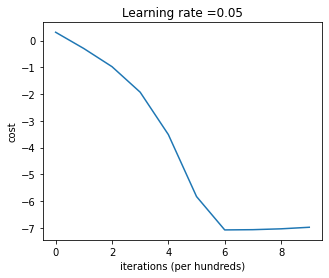

In [46]:
data = transformTarVar(data, dependantVarColumn)

X_train, X_test, Y_train, Y_test = trainTestTransform(data, sizeTrainingData)

parameters, costs, caches = L_layer_model(X_train, Y_train, layers_dims, learning_rate, num_iterations = 200, optimizer = "adam", print_cost = True)

plot_costs(costs, learning_rate)

#Best parameters for the data ----- LR-0.05, Epochs-200 with target variable in the form of 0/1
#Whats weird that gradients start to explode and accuracy decreases to 69% if we set the target variable to -1/1 keeping all other hyper parameters fixed


parameters_optimal, costs_optimal, caches_optimal = L_layer_model(X_train, Y_train, layers_dims_optimal,0.005, num_iterations = 200, print_cost = True)
plot_costs(costs_optimal, 0.05)

**Training Accuracy**

In [47]:
predictions_train = predict(X_train, Y_train, parameters)

print("Optimal NN")
predictions_train_optimal = predict(X_train, Y_train, parameters_optimal)


Accuracy: 0.6946216955332725
Optimal NN
Accuracy: 0.7219690063810391


**Dev Accuracy**

In [48]:
predictions_test = predict(X_test.T, Y_test, parameters)

print("Optimal NN")
predictions_test_optimal = predict(X_test.T, Y_test, parameters_optimal)

Accuracy: 0.0
Optimal NN
Accuracy: 0.13818181818181818


**Code to fragment the network into smaller networks**

In [ ]:
pip install pulp

In [ ]:
from pulp import *
import random

**Declaring parameters for the linear programming problem**

In [ ]:
#no. of subnetworks
subnets = 4

#weight of final output layer
weights_output_layer = caches[8][0][1].T

weights_len = len(weights_output_layer)

penultimate_output = caches[8][0][0]

output = Y_train.T

**Defining Linear Programming Problem**

In [ ]:
model_sub = LpProblem("Network_Decomposition", LpMinimize)

**Declaring Decision Variables**

In [ ]:
variable_names_subnetwork = [str(i)+str(j) for j in range(1, subnets+1) for i in range(1, weights_len+1)]
variable_names_subnetwork.sort()
# print("Variable Indices:", variable_names_subnetwork)

In [ ]:
DV_variables_sub = LpVariable.matrix("X", variable_names_subnetwork)
allocation_sub = np.array(DV_variables_sub).reshape(weights_len, subnets)
# print("Decision Variable/Allocation Matrix: ")
# print(allocation_sub)

In [ ]:
model_sub +=  0
print(model_sub)

**Defining constraint which ensures the subnetwork completely decomposes the whole network**

$\sum \limits _{k=1} ^{K} {\alpha}_{m,k} = W_{1,m} ^{L+1}$ &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; ${1}\le m \le M $

In [ ]:
for i in range(weights_len):
    # print(lpSum(allocation_sub[i][j] for j in range(subnets)) == weights_output_layer[i])
    model_sub += lpSum(allocation_sub[i][j] for j in range(subnets)) == weights_output_layer[i] , "Decomposition Constraint 1" + str(i)

**Defining constraint that zeros out half entries randomly for each column of alpha, encouraging diversity among sub-networks**

${\alpha}_{m_{j,k},k} = 0$ &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp;  ${1}\le j \le M/2,  {1}\le k \le K$ 

In [ ]:
for k in range(len(penultimate_output[0])):
  for i in range(weights_len):
    for j in range(subnets):
      model_sub += lpSum(allocation_sub[i][j]*penultimate_output[:,k][i]*output[k][0]) >= 0, "Decomposition Constraint 2" + str(k) + "_" + str(i) + str(j)

**Each sub-network achieves 100% accuracy on training data**

$(\sum \limits _{m=1} ^{M} {\alpha}_{m,k}g({z} _{m} ^{L}(x _{i})) \ )y_{i}= W_{1,m} ^{L+1}$ &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; &emsp; ${1}\le i \le n,  {1}\le k \le K$ 

In [ ]:
lastLayerIpCountList = [i for i in range(weights_len)]

for j in range(subnets):
    randomPickedIp = random.sample(lastLayerIpCountList, 50)
    for i in randomPickedIp:
        # print(allocation_sub[i][j] == 0)
        model_sub += allocation_sub[i][j] == 0, "Decomposition Constraint 3" + str(i) + "_" + str(j)

In [ ]:
model_sub.writeLP("Network_Frag.lp")

#model.solve()
model_sub.solve(PULP_CBC_CMD())

status =  LpStatus[model_sub.status]

print("Linear Programming Problem status:",status)

print("Total Cost:", model_sub.objective.value())

In [ ]:
def printModelVariables(model_sub):
  print(model_sub.variables())
  for v in model_sub.variables():
      try:
          print(v.name,"=", v.value())
      except:
          print("error couldnt find value")

**Creating a dictionary to store each sub-network weights**

In [ ]:
subnetwork_dict = {}
for subnet in range(subnets):
  templist =[element.value() for element in allocation_sub[:,subnet] ]
  subnetwork_dict["subnetwork"+str(subnet)] = np.array(templist).reshape(1,100)

**Testing each subnetwork on training data**

In [ ]:
import copy
subnet_parameters = copy.deepcopy(parameters)

In [ ]:
for network in subnetwork_dict:
  subnet_parameters["W9"] = subnetwork_dict[network]
  print(network, "Training")
  subnetwork_predictions_train = predict(X_train, Y_train, subnet_parameters)
  print(network, "Test")
  subnetwork_predictions_test = predict(X_test.T, Y_test, parameters)